# F1 LoRA Fine-Tuning and Evaluation Notebook



This notebook is my end-to-end pipeline for fine-tuning small open models on a Formula 1 QA dataset using LoRA, then evaluating them on a large multiple-choice benchmark.

I wrote this for my CS6220 final project, so the explanations are in my own words and assume I run everything locally on my machine.

---

## Goals

- Fine-tune two base models on F1 question–answer pairs:
  - `mistralai/Mistral-7B-v0.3`
  - `meta-llama/Meta-Llama-3.1-8B-Instruct` (referred to here as LLaMA 3.1 8B)
- Teach them to answer F1 questions correctly and consistently.
- Evaluate them on a big multiple-choice dataset and measure accuracy.

The notebook should:

1. Build the training data from my processed QA JSON files.
2. Run LoRA fine-tuning for Mistral and LLaMA.
3. Evaluate both models on the same MC dataset using a robust scoring method (no fragile JSON parsing).
4. Save all logs, metrics, and plots so I can compare models later, even if I reset the kernel between runs.

---

## Folder structure, inputs and outputs

The notebook assumes the project is laid out like this:

- **Project root and notebook**
  - `PROJECT_ROOT` is inferred from the notebook path.
  - The notebook itself lives under  
    `PROJECT_ROOT/notebooks/`  
    (for me it is something like  
    `D:\Projects\CS6220\Final Project\f1-conversational-ai-main\notebooks\f1_lora_finetune.ipynb`).

- **Training QA data (for SFT)**
  - `F1_QA_INPUT_DIR = PROJECT_ROOT / "data" / "processed" / "f1_qa"`
  - This folder contains files like `qa_1.json`, `qa_2.json`, …  
    Each file has:
    - `article_number`, `source`, `title`, `summary`
    - `qa_pairs`, where each pair has:
      - `question`
      - `correct_answer`
      - `wrong_options` (three distractors)
      - `rephrased_question`
      - `options` dict with A, B, C, D
      - `ground_truth_correct_option` (the letter)
      - `prompt` (original MC prompt used earlier)

  - In this notebook I **do not** reuse the old MC prompt.  
    Instead I build my own SFT text:
    > You are a knowledgeable Formula 1 expert.  
    > Answer the question briefly and accurately.  
    > Question: …  
    > Answer: {correct_answer}

- **Eval MC data (big dataset for scoring)**
  - `BIG_EVAL_DATASET_DIR = PROJECT_ROOT / "data" / "processed" / "big_data_dataset_evalScripts" / "dataset"`
  - Contains about 527 files like `qa_1.json`, `qa_2.json`, … with:
    - `qa_pairs` and the same fields as above.
  - For evaluation I only use:
    - `rephrased_question` (fallback to `question`)
    - `options` (A, B, C, D)
    - `ground_truth_correct_option`.

- **Processed prompts (optional cache)**
  - `EVAL_OUTPUT_DIR = PROJECT_ROOT / "data" / "processed" / "LoRA_Processed_Inputs"`
  - Used to save the processed SFT prompts and metadata so I do not have to recompute them each time.

- **Model outputs and logs**
  - `RESULTS_DIR = PROJECT_ROOT / "results" / "LoRA_Results"`
    - Per model LoRA weights:
      - `RESULTS_DIR / "mistral_lora"`  
      - `RESULTS_DIR / "llama_lora"`
    - Training logs:
      - `mistral_train_log.json`, `llama_train_log.json`
      - `mistral_train_meta.json`, `llama_train_meta.json`
  - `EVAL_RESULTS_DIR` (under `RESULTS_DIR`)  
    - Evaluation outputs, for example:
      - `mistral_bigdata_eval_results_scoring.json`
      - `llama_bigdata_eval_results_scoring.json`
    - Final CSVs:
      - `epoch_results.csv` (epoch-level MC accuracy and times)
      - `summary_results.csv` (one row per model, final accuracy, train time, eval time)

---

## Requirements and environment

This notebook expects:

- Python environment with:
  - `torch` and a working GPU (A100 type is what I used)
  - `transformers`
  - `peft`
  - `accelerate`
  - `bitsandbytes` (for 4-bit loading)
  - `pandas`, `matplotlib`
- Access to the HF model IDs listed in `MODELS`.
- Enough GPU memory to fine-tune 7B–8B models with LoRA and gradient checkpointing.

The first code cells check GPU details and print:

- Device type
- GPU name and total memory
- Torch and transformers versions

If something looks wrong there, the rest of the notebook will probably not behave well.

---

## What actually happens in each logical section

I structured the notebook in blocks. Roughly:

1. **Environment and GPU check**
   - Import packages.
   - Print basic system info, GPU type, memory, and key library versions.

2. **Project paths and configuration**
   - Infer `NOTEBOOK_DIR` and `PROJECT_ROOT`.
   - Define:
     - `F1_QA_INPUT_DIR`
     - `EVAL_OUTPUT_DIR`
     - `BIG_EVAL_DATASET_DIR`
     - `RESULTS_DIR` and `EVAL_RESULTS_DIR`
   - Define `MODELS` list with Mistral and LLaMA configs.
   - Set common hyperparameters:
     - `NUM_EPOCHS`, `BATCH_SIZE`, `LEARNING_RATE`, `WARMUP_RATIO`, `MAX_SEQ_LEN`.

3. **LoRA configuration utilities**
   - Helper function `create_tokenizer(model_id)` that:
     - Loads the tokenizer from HF.
     - Ensures `pad_token_id` is set (fall back to `eos_token_id` if needed).
   - Helper function `create_base_model(model_id)` that:
     - Loads the base model in 4-bit with `bitsandbytes`.
     - Puts it on the GPU.
   - Helper function `apply_lora(model)` that:
     - Wraps the base model with LoRA layers using `peft`.
   - All LoRA hyperparameters (rank, alpha, dropout) are defined here.

4. **Building the SFT training dataset**
   - Read all QA JSON files from `F1_QA_INPUT_DIR`.
   - For each `qa_pair`, build a simple SFT string:
     - Short instruction
     - Question
     - Correct answer only (no distractors).
   - Save everything into a `datasets.Dataset` called `train_dataset`, with fields:
     - `"text"` (prompt + answer)
     - `"q_id"` (for tracking).
   - Print the first 5 raw examples so I can inspect exactly what the model sees.

5. **Tokenization helper**
   - `tokenize_sft_function(examples, tokenizer)`:
     - Tokenizes the `"text"` field.
     - Applies truncation and padding to `MAX_SEQ_LEN`.
   - This is used for both Mistral and LLaMA to produce model-specific tokenized datasets.

6. **Mistral LoRA training**
   - Create Mistral tokenizer and tokenized dataset `mistral_ds`.
   - Print a few decoded tokenized examples, which show a lot of `<s>` tokens at the end because of padding.
     - This is expected: the dataset is padded with `<s>` (BOS/EOS) as pad token.
   - Load base Mistral model and wrap it with LoRA.
   - Set `pad_token_id` for model and tokenizer.
   - Configure `TrainingArguments`:
     - Epochs, batch size, gradient accumulation, learning rate, warmup, FP16, no logging to external services.
   - Run `Trainer.train()` and print training loss every few steps.
   - Save:
     - LoRA weights into `RESULTS_DIR / "mistral_lora"`
     - Training log (`mistral_train_log.json`)
     - Training meta (`mistral_train_meta.json`).

7. **Mistral evaluation with MC scoring (no generation)**
   - Load evaluation questions from `BIG_EVAL_DATASET_DIR` using:
     - `load_big_eval_questions_for_scoring`.
   - For each question:
     - Build a fresh prompt that matches the SFT style:

       > You are a knowledgeable Formula 1 expert.  
       > Answer the question briefly and accurately.  
       > Question: …  
       > Options: A: … B: … C: … D: …  
       > Answer:

     - For each option A, B, C, D:
       - Call `score_option_logprob`:
         - Concatenate prompt + option text.
         - Run the model once.
         - Compute average log probability of the answer tokens.
     - Choose the option letter with the highest average log-prob.
   - The key point is:  
     There is **no generation** and **no JSON parsing** here.  
     I only ask the model “How likely is it that the answer is this string” four times and pick the best.
   - `run_big_mc_eval_scoring`:
     - Prints progress every 20 questions:
       - `Scoring question i/N...`
       - Predicted option and ground truth
       - Per-option scores
     - At the end it prints:
       - Total number of questions
       - Number correct
       - Overall accuracy
       - Evaluation time
     - Stores detailed per-question records in a JSON under `EVAL_RESULTS_DIR`.

   - Current outcome for Mistral (on my run):  
     about **72.3% MC accuracy** on 1581 questions.

8. **LLaMA LoRA training**
   - Same logic as Mistral, but for `meta-llama/Meta-Llama-3.1-8B-Instruct`:
     - Build tokenizer and tokenized dataset `llama_ds` from `train_dataset`.
     - Print first raw and tokenized examples for sanity.
     - Load base LLaMA model and apply LoRA.
     - Train with the same hyperparameters.
     - Save:
       - `llama_lora` directory
       - `llama_train_log.json`
       - `llama_train_meta.json`.

9. **LLaMA evaluation with MC scoring**
   - Reuse the same scoring functions used for Mistral:
     - `load_big_eval_questions_for_scoring`
     - `build_scoring_prompt`
     - `score_option_logprob`
     - `run_big_mc_eval_scoring`
   - Load the LLaMA LoRA adapter and evaluate on the same MC dataset.
   - Save results to:
     - `llama_bigdata_eval_results_scoring.json`
   - Append a summary row for LLaMA into the in-memory `summary_rows` list.

10. **Collecting results and plotting**
    - Build:
      - `epoch_results_df` from `all_epoch_logs` (epoch-level information, if available).
      - `summary_df` from `summary_rows` (one row per model).
    - Save:
      - `epoch_results.csv`
      - `summary_results.csv`
    - Plot:
      - MC accuracy per epoch by model (if epoch logs exist).
      - Training time per model.
      - Final MC accuracy per model.
      - Evaluation time per model.

    Note: because I sometimes reset the kernel between model runs, the notebook also supports reading existing JSONs and CSVs back from disk and reconstructing `summary_df` so that both models (Mistral and LLaMA) appear in the final plots.

---

## Challenges along the way

Some of the main issues I hit and how this notebook addresses them:

1. **Generation-based MC evaluation failed**
   - When I tried to ask the model to output a JSON like:
     ```json
     { "model_correct_option": "C", "justification": "..." }
     ```
     the model often replied with just `</s>` or random text.  
     The parsing code could not reliably extract the answer, and I ended up with `Parsed: 0, Skipped: 1581`.

2. **EOS and padding**
   - Mistral and LLaMA use `<s>` and `</s>` tokens, and sometimes the tokenizer reused `<s>` as pad.
   - This is why decoded tokenized examples show many `<s>` at the end.
   - The notebook explicitly aligns `pad_token_id` with `eos_token_id` so that generation and losses behave more predictably.


---

## Current outcomes

Right now, after the scoring-based evaluation is in place:

- **Mistral-7B LoRA**
  - Successfully trains on my F1 QA SFT dataset.
  - Reaches around **72% multiple-choice accuracy** on the 1,581 held-out questions using log-prob scoring.
  - Training and eval runtimes are recorded in `summary_results.csv`.

- **LLaMA-3.1-8B-Instruct LoRA**
  - Fine-tuning and scoring evaluation follow the exact same pipeline.
  - Final accuracy and timing are also written into `summary_results.csv` once the evaluation run completes.

The notebook is now stable: data loading, training, and evaluation are aligned, and the scoring method is robust to model output quirks. If I want to update anything later (change models, tweak prompts, add epochs), I can do it in a controlled way without breaking the whole pipeline.


## Cell 1 – Environment and GPU check

In [1]:

import sys
import subprocess
import importlib

def ensure_package(pkg):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for p in [
    "torch", "transformers", "datasets", "peft",
    "accelerate", "bitsandbytes", "trl", "pandas", "numpy", "matplotlib",
    "huggingface_hub"
]:
    ensure_package(p)

import torch
import platform
import json
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig,
)
from datasets import Dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
from huggingface_hub import login
from pathlib import Path

print("Python:", sys.version)
print("Platform:", platform.platform())
print("Transformers version:", transformers.__version__)
print("Torch version:", torch.__version__)

MACHINE_INFO = {}

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA available:", torch.cuda.is_available())
    print("GPU count:", torch.cuda.device_count())
    gpu_name = torch.cuda.get_device_name(0)
    props = torch.cuda.get_device_properties(0)
    gpu_mem_gb = round(props.total_memory / 1024**3, 2)
    print("Current GPU:", gpu_name)
    print("GPU total memory (GB):", gpu_mem_gb)
    MACHINE_INFO["device_type"] = "cuda"
    MACHINE_INFO["gpu_name"] = gpu_name
    MACHINE_INFO["gpu_memory_gb"] = gpu_mem_gb
else:
    device = torch.device("cpu")
    print("CUDA not available; using CPU")
    MACHINE_INFO["device_type"] = "cpu"
    MACHINE_INFO["gpu_name"] = None
    MACHINE_INFO["gpu_memory_gb"] = None

MACHINE_INFO["platform"] = platform.platform()
MACHINE_INFO["python_version"] = sys.version


Python: 3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
Transformers version: 4.57.1
Torch version: 2.6.0+cu124
CUDA available: True
GPU count: 1
Current GPU: NVIDIA GeForce RTX 4090 Laptop GPU
GPU total memory (GB): 15.99


## Cell 2 – Paths, config and Hugging Face token

In [2]:
from pathlib import Path

# Use the notebook folder as base, then go one level up to project root
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Input QA JSONs (only these are used as inputs)
F1_QA_INPUT_DIR = PROJECT_ROOT / "data" / "processed" / "f1_qa"

# Final jsons used for training/testing and tracking correct responses
EVAL_OUTPUT_DIR = PROJECT_ROOT / "data" / "processed" / "LoRA_Processed_Inputs"
EVAL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Where models and training outputs (LoRA checkpoints, logs, etc.) are saved
RESULTS_DIR = PROJECT_ROOT / "results" / "LoRA Results" / "Outputs"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Where evaluation result files (aggregated metrics, etc.) can be saved
EVAL_RESULTS_DIR = PROJECT_ROOT / "results" / "LoRA Results" / "Eval_Results"
EVAL_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Cache directory for base model downloads to avoid re-downloading
MODEL_CACHE_DIR = PROJECT_ROOT / "models"
MODEL_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Hugging Face key (relative to project root)
LOCAL_KEY_PATH = PROJECT_ROOT / "00_KamyarKeys" / "key.json"

def load_hf_token():
    if "HF_TOKEN" in os.environ and os.environ["HF_TOKEN"]:
        return os.environ["HF_TOKEN"]
    if LOCAL_KEY_PATH.exists():
        with open(LOCAL_KEY_PATH, "r", encoding="utf-8") as f:
            key_data = json.load(f)
        token = key_data.get("Token", {}).get("value")
        if token:
            os.environ["HF_TOKEN"] = token
            return token
    return None

hf_token = load_hf_token()
if hf_token:
    login(token=hf_token)
    print("Hugging Face login successful.")
else:
    print("Warning: Hugging Face token not found. Place key.json correctly or set HF_TOKEN.")

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

MAX_SEQ_LEN = 1024
BATCH_SIZE = 2
NUM_EPOCHS = 2
LEARNING_RATE = 2e-4
WARMUP_RATIO = 0.03
LORA_R = 8
LORA_ALPHA = 16
LORA_DROPOUT = 0.05

MODELS = [
    {
        "id": "mistralai/Mistral-7B-v0.1",
        "name": "mistral-7b",
    },
    {
        "id": "meta-llama/Llama-3.1-8B-Instruct",
        "name": "llama-3.1-8b-instruct",
    },
]

print("Notebook dir:", NOTEBOOK_DIR)
print("Project root:", PROJECT_ROOT)
print("Input QA dir:", F1_QA_INPUT_DIR)
print("LoRA processed inputs dir:", EVAL_OUTPUT_DIR)
print("LoRA outputs dir:", RESULTS_DIR)
print("LoRA eval results dir:", EVAL_RESULTS_DIR)


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Hugging Face login successful.
Notebook dir: D:\Projects\CS6220\Final Project\f1-conversational-ai-main\notebooks
Project root: D:\Projects\CS6220\Final Project\f1-conversational-ai-main
Input QA dir: D:\Projects\CS6220\Final Project\f1-conversational-ai-main\data\processed\f1_qa
LoRA processed inputs dir: D:\Projects\CS6220\Final Project\f1-conversational-ai-main\data\processed\LoRA_Processed_Inputs
LoRA outputs dir: D:\Projects\CS6220\Final Project\f1-conversational-ai-main\results\LoRA Results\Outputs
LoRA eval results dir: D:\Projects\CS6220\Final Project\f1-conversational-ai-main\results\LoRA Results\Eval_Results


## Cell 3 – Load QA JSON files

In [3]:

def load_f1_qa_files(input_dir: Path):
    records = []
    if not input_dir.exists():
        raise FileNotFoundError(f"Input directory not found: {input_dir}")
    for path in sorted(input_dir.glob("*.json")):
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        article_number = data.get("article_number")
        source = data.get("source")
        title = data.get("title")
        summary = data.get("summary")
        link = data.get("link")
        qa_pairs = data.get("qa_pairs", [])
        for idx, qa in enumerate(qa_pairs):
            question = qa["question"]
            correct_answer = qa["correct_answer"]
            wrong_options = qa.get("wrong_options", [])
            records.append(
                {
                    "article_number": article_number,
                    "source": source,
                    "title": title,
                    "summary": summary,
                    "link": link,
                    "q_id": f"{article_number}_{idx}",
                    "question": question,
                    "correct_answer": correct_answer,
                    "wrong_options": wrong_options,
                }
            )
    return pd.DataFrame(records)

df_qa = load_f1_qa_files(F1_QA_INPUT_DIR)
print("Total QA pairs:", len(df_qa))
display(df_qa.head())


Total QA pairs: 1536


,article_number,source,title,summary,link,q_id,question,correct_answer,wrong_options
0,1,Motorsport Magazine,Verstappen nears historic F1 comeback - US GP ...,Verstappen's double win in Austin moved him cl...,https://www.motorsportmagazine.com/articles/si...,1_0,Which driver achieved a double win at the US G...,Max Verstappen,"[Lewis Hamilton, Charles Leclerc, Sergio Pérez]"
1,1,Motorsport Magazine,Verstappen nears historic F1 comeback - US GP ...,Verstappen's double win in Austin moved him cl...,https://www.motorsportmagazine.com/articles/si...,1_1,What challenge did McLaren face during the US ...,Tough questions over its strategy,"[Performance issues with the car, Driver penal..."
2,1,Motorsport Magazine,Verstappen nears historic F1 comeback - US GP ...,Verstappen's double win in Austin moved him cl...,https://www.motorsportmagazine.com/articles/si...,1_2,What type of race experience did fans have dur...,Another processional race,"[An exciting battle for the lead, Multiple saf..."
3,10,Motorsport Magazine,2025 US Grand Prix: Qualifying start time and ...,Start time for qualifying ahead of the 2025 Un...,https://www.motorsportmagazine.com/articles/si...,10_0,What is the typical format of a Formula 1 qual...,"Three knockout rounds: Q1, Q2, and Q3.","[Single lap time trial for all drivers., Two 3..."
4,10,Motorsport Magazine,2025 US Grand Prix: Qualifying start time and ...,Start time for qualifying ahead of the 2025 Un...,https://www.motorsportmagazine.com/articles/si...,10_1,In which city is the United States Grand Prix ...,"Austin, Texas.","[Miami, Florida., Los Angeles, California., Ne..."


## Cell 4 – Build multiple-choice prompts and answer key

In [4]:

def build_mc_prompts(df: pd.DataFrame, seed: int = 123):
    rng = random.Random(seed)
    prompts = []
    answer_key = []

    for _, row in df.iterrows():
        qid = row["q_id"]
        question = row["question"]
        correct = row["correct_answer"]
        wrongs = list(row["wrong_options"])
        all_options = [correct] + wrongs
        if len(all_options) != 4:
            continue
        rng.shuffle(all_options)
        letters = ["A", "B", "C", "D"]
        letter_to_option = {ltr: opt for ltr, opt in zip(letters, all_options)}
        correct_letter = next(ltr for ltr, opt in letter_to_option.items() if opt == correct)

        prompt_text = (
            "You are a knowledgeable Formula 1 expert.\n"
            "Answer the following multiple-choice question.\n\n"
            f"Question: {question}\n"
            "Options:\n"
            f"A. {letter_to_option['A']}\n"
            f"B. {letter_to_option['B']}\n"
            f"C. {letter_to_option['C']}\n"
            f"D. {letter_to_option['D']}\n\n"
            'Respond in JSON with two fields: "answer" (one of "A","B","C","D") and '
            '"explanation" (one sentence explaining your choice).'
        )

        prompts.append(
            {
                "q_id": qid,
                "article_number": row["article_number"],
                "question": question,
                "options": letter_to_option,
                "prompt": prompt_text,
            }
        )

        answer_key.append(
            {
                "q_id": qid,
                "correct_letter": correct_letter,
                "correct_answer": correct,
                "article_number": row["article_number"],
            }
        )

    return prompts, answer_key

mc_prompts, mc_answer_key = build_mc_prompts(df_qa, seed=SEED)
print("MC prompts:", len(mc_prompts))

mc_prompts_path = EVAL_OUTPUT_DIR / "mc_prompts.json"
mc_answer_key_path = EVAL_OUTPUT_DIR / "mc_answer_key.json"

with open(mc_prompts_path, "w", encoding="utf-8") as f:
    json.dump(mc_prompts, f, indent=2, ensure_ascii=False)

with open(mc_answer_key_path, "w", encoding="utf-8") as f:
    json.dump(mc_answer_key, f, indent=2, ensure_ascii=False)

print("Saved MC prompts to:", mc_prompts_path)
print("Saved answer key to:", mc_answer_key_path)


MC prompts: 1536
Saved MC prompts to: D:\Projects\CS6220\Final Project\f1-conversational-ai-main\data\processed\LoRA_Processed_Inputs\mc_prompts.json
Saved answer key to: D:\Projects\CS6220\Final Project\f1-conversational-ai-main\data\processed\LoRA_Processed_Inputs\mc_answer_key.json


## Cell 5 – Build supervised training texts

In [5]:

def build_train_texts(df: pd.DataFrame):
    texts = []
    for _, row in df.iterrows():
        q = row["question"]
        a = row["correct_answer"]
        text = (
            "You are a knowledgeable Formula 1 expert.\n"
            "Answer the question briefly and accurately.\n\n"
            f"Question: {q}\n"
            f"Answer: {a}"
        )
        texts.append({"text": text, "q_id": row["q_id"]})
    return texts

train_records = build_train_texts(df_qa)
train_dataset = Dataset.from_list(train_records)
print(train_dataset[0])


{'text': 'You are a knowledgeable Formula 1 expert.\nAnswer the question briefly and accurately.\n\nQuestion: Which driver achieved a double win at the US Grand Prix in Austin?\nAnswer: Max Verstappen', 'q_id': '1_0'}


## Cell 6 – Helper utilities (tokenization, model loading, LoRA, evaluation)

In [6]:
from transformers.trainer_callback import TrainerCallback, TrainerState, TrainerControl

def create_tokenizer(model_id: str):
    tokenizer = AutoTokenizer.from_pretrained(
        model_id,
        use_fast=True,
        token=hf_token,
    )
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"
    return tokenizer

def get_model_cache_subdir(model_id: str):
    safe_name = model_id.replace("/", "_")
    return MODEL_CACHE_DIR / safe_name

def create_base_model(model_id: str):
    cache_dir = get_model_cache_subdir(model_id)
    cache_dir.mkdir(parents=True, exist_ok=True)

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.float16,
        token=hf_token,
        trust_remote_code=True,
        cache_dir=str(cache_dir),
    )
    return model

def apply_lora(model):
    lora_config = LoraConfig(
        r=LORA_R,
        lora_alpha=LORA_ALPHA,
        target_modules=[
            "q_proj", "k_proj", "v_proj", "o_proj",
            "gate_proj", "up_proj", "down_proj"
        ],
        lora_dropout=LORA_DROPOUT,
        bias="none",
        task_type="CAUSAL_LM",
    )
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()
    return model

def tokenize_sft_function(examples, tokenizer):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_SEQ_LEN,
        padding="max_length",
    )
    # Add labels so the model can compute loss
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

def parse_model_json_output(text: str):
    try:
        start = text.find("{")
        end = text.rfind("}")
        if start == -1 or end == -1 or end <= start:
            return None
        snippet = text[start : end + 1]
        obj = json.loads(snippet)
        ans = obj.get("answer")
        expl = obj.get("explanation")
        if isinstance(ans, str):
            ans = ans.strip().upper()
        return {"answer": ans, "explanation": expl}
    except Exception:
        return None

def run_mc_evaluation(model, tokenizer, mc_prompts, mc_answer_key, max_new_tokens=64):
    model.eval()
    id_to_correct = {item["q_id"]: item["correct_letter"] for item in mc_answer_key}
    correct = 0
    total = 0
    details = []

    for prompt in mc_prompts:
        qid = prompt["q_id"]
        text = prompt["prompt"]
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_SEQ_LEN,
        )
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                num_beams=1,
            )

        full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        parsed = parse_model_json_output(full_text)
        pred = None
        if parsed and parsed["answer"] in ["A", "B", "C", "D"]:
            pred = parsed["answer"]
        gold = id_to_correct.get(qid)
        is_correct = int(pred == gold)
        details.append(
            {
                "q_id": qid,
                "pred": pred,
                "gold": gold,
                "is_correct": is_correct,
                "raw_output": full_text,
            }
        )
        if gold is not None:
            total += 1
            if is_correct:
                correct += 1

    accuracy = correct / total if total > 0 else 0.0
    return accuracy, details

class MCEvalCallback(TrainerCallback):
    def __init__(self, model_name: str, tokenizer, mc_prompts, mc_answer_key, results_log: list, output_dir: Path):
        self.model_name = model_name
        self.tokenizer = tokenizer
        self.mc_prompts = mc_prompts
        self.mc_answer_key = mc_answer_key
        self.results_log = results_log
        self.output_dir = Path(output_dir)

    def on_epoch_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        epoch = state.epoch
        start = time.perf_counter()
        acc, _ = run_mc_evaluation(
            kwargs["model"],
            self.tokenizer,
            self.mc_prompts,
            self.mc_answer_key,
        )
        duration = time.perf_counter() - start
        checkpoint_dir = self.output_dir / f"checkpoint-{state.global_step}"
        record = {
            "model_name": self.model_name,
            "epoch": epoch,
            "mc_eval_accuracy": acc,
            "mc_eval_time_sec": duration,
            "global_step": state.global_step,
            "checkpoint_dir": str(checkpoint_dir),
        }
        print(f"[{self.model_name}] Epoch {epoch:.2f} MC accuracy: {acc:.4f}, time: {duration:.2f}s")
        self.results_log.append(record)
        return control


## Cell 7 – Prepare containers for results

In [7]:

all_epoch_logs = []
summary_rows = []


## Cell 8 - Seperated Train and Test (Mistral)

### Mistral

#### Train

In [15]:
# === Mistral LoRA training (with debug prints) ===

import gc
import time
import json
import torch
from transformers import TrainingArguments, Trainer

# Sanity check: show the first 5 *raw* training examples before tokenization
print("=== First 5 raw training examples from train_dataset ===")
for i in range(min(5, len(train_dataset))):
    print(f"\n--- Raw example {i} ---")
    print(train_dataset[i])

# ---------------- Mistral config & tokenizer ----------------
mistral_cfg = next(m for m in MODELS if m["name"] == "mistral-7b")
MISTRAL_ID = mistral_cfg["id"]
MISTRAL_NAME = mistral_cfg["name"]

mistral_tokenizer = create_tokenizer(MISTRAL_ID)

# Tokenize SFT dataset for Mistral
mistral_ds = train_dataset.map(
    lambda examples: tokenize_sft_function(examples, mistral_tokenizer),
    batched=True,
    remove_columns=train_dataset.column_names,
)
print("\nMistral tokenized dataset size:", len(mistral_ds))

# Optional: decode the first 3 tokenized prompts to see what the model actually gets
print("\n=== First 3 tokenized Mistral training prompts (decoded) ===")
for i in range(min(3, len(mistral_ds))):
    ids = mistral_ds[i]["input_ids"]
    text = mistral_tokenizer.decode(ids, skip_special_tokens=False)
    print(f"\n--- Tokenized example {i} ---")
    print(text[:1000])  # truncate just in case

# ---------------- Mistral base model + LoRA ----------------
mistral_base_model = create_base_model(MISTRAL_ID)
mistral_lora_model = apply_lora(mistral_base_model)

# Make sure pad_token_id is set (helps both training and later eval)
if mistral_tokenizer.pad_token_id is None and mistral_tokenizer.eos_token_id is not None:
    mistral_tokenizer.pad_token_id = mistral_tokenizer.eos_token_id
if mistral_lora_model.config.pad_token_id is None and mistral_lora_model.config.eos_token_id is not None:
    mistral_lora_model.config.pad_token_id = mistral_lora_model.config.eos_token_id

mistral_output_dir = RESULTS_DIR / "mistral_lora"
mistral_output_dir.mkdir(parents=True, exist_ok=True)

mistral_train_args = TrainingArguments(
    output_dir=str(mistral_output_dir),
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    logging_steps=10,
    save_strategy="epoch",
    fp16=True,
    report_to=[],
)

mistral_trainer = Trainer(
    model=mistral_lora_model,
    args=mistral_train_args,
    train_dataset=mistral_ds,
    tokenizer=mistral_tokenizer,
)

mistral_train_start = time.perf_counter()
mistral_train_result = mistral_trainer.train()
mistral_train_time = time.perf_counter() - mistral_train_start

print("\nMistral training runtime (sec):", round(mistral_train_time, 2))

mistral_trainer.save_model()

mistral_log_history = mistral_trainer.state.log_history
mistral_loss_entries = [e for e in mistral_log_history if "loss" in e]
mistral_final_train_loss = mistral_loss_entries[-1]["loss"] if mistral_loss_entries else None

with open(mistral_output_dir / "mistral_train_log.json", "w", encoding="utf-8") as f:
    json.dump(mistral_log_history, f, indent=2)

mistral_train_meta = {
    "model_name": MISTRAL_NAME,
    "train_time_sec": mistral_train_time,
    "final_train_loss": mistral_final_train_loss,
    "num_epochs": NUM_EPOCHS,
    "num_steps": len(mistral_loss_entries),
    "machine_info": MACHINE_INFO,
}
with open(mistral_output_dir / "mistral_train_meta.json", "w", encoding="utf-8") as f:
    json.dump(mistral_train_meta, f, indent=2)

del mistral_trainer
del mistral_lora_model
del mistral_base_model
torch.cuda.empty_cache()
gc.collect()


=== First 5 raw training examples from train_dataset ===

--- Raw example 0 ---
{'text': 'You are a knowledgeable Formula 1 expert.\nAnswer the question briefly and accurately.\n\nQuestion: Which driver achieved a double win at the US Grand Prix in Austin?\nAnswer: Max Verstappen', 'q_id': '1_0'}

--- Raw example 1 ---
{'text': 'You are a knowledgeable Formula 1 expert.\nAnswer the question briefly and accurately.\n\nQuestion: What challenge did McLaren face during the US Grand Prix?\nAnswer: Tough questions over its strategy', 'q_id': '1_1'}

--- Raw example 2 ---
{'text': 'You are a knowledgeable Formula 1 expert.\nAnswer the question briefly and accurately.\n\nQuestion: What type of race experience did fans have during the US GP?\nAnswer: Another processional race', 'q_id': '1_2'}

--- Raw example 3 ---
{'text': 'You are a knowledgeable Formula 1 expert.\nAnswer the question briefly and accurately.\n\nQuestion: What is the typical format of a Formula 1 qualifying session?\nAnswer: T

Map:   0%|          | 0/1536 [00:00<?, ? examples/s]

`torch_dtype` is deprecated! Use `dtype` instead!



Mistral tokenized dataset size: 1536

=== First 3 tokenized Mistral training prompts (decoded) ===

--- Tokenized example 0 ---
<s> You are a knowledgeable Formula 1 expert.
Answer the question briefly and accurately.

Question: Which driver achieved a double win at the US Grand Prix in Austin?
Answer: Max Verstappen</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\kamiy\AppData\Local\Temp\ipykernel_72008\3560160232.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  mistral_trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


trainable params: 20,971,520 || all params: 7,262,703,616 || trainable%: 0.2888


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
d:\Projects\CS6220\Final Project\f1-conversational-ai-main\.venv\lib\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,4.784200
20,0.083700
30,0.044300
40,0.041500
50,0.036600
60,0.037100
70,0.035800
80,0.036600
90,0.034600
100,0.034500


d:\Projects\CS6220\Final Project\f1-conversational-ai-main\.venv\lib\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



Mistral training runtime (sec): 4690.78


46127

#### Test

##### Using Dharmics' Evaluation

In [10]:
# === Mistral LoRA evaluation on big_data_dataset_evalScripts using scoring (no generation) ===

import gc
import json
import time
from pathlib import Path

import torch
import torch.nn.functional as F
from peft import PeftModel

BIG_EVAL_DATASET_DIR = PROJECT_ROOT / "data" / "processed" / "big_data_dataset_evalScripts" / "dataset"

def load_big_eval_questions_for_scoring(input_dir: Path):
    """
    Load eval questions from qa_*.json.

    We use:
      - question (or rephrased_question if available)
      - options (dict A,B,C,D)
      - ground_truth_correct_option (letter)
    We IGNORE the dataset 'prompt' and build our own prompt that matches training style.
    """
    examples = []
    qa_files = sorted(input_dir.glob("qa_*.json"))
    print(f"Loading evaluation QA from {len(qa_files)} files in {input_dir}")
    for path in qa_files:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        qa_pairs = data.get("qa_pairs", [])
        try:
            file_index = int(path.stem.split("_")[1])
        except Exception:
            file_index = None
        for idx, qa in enumerate(qa_pairs):
            question = qa.get("rephrased_question", qa["question"])
            options = qa["options"]
            gt = qa["ground_truth_correct_option"]
            examples.append(
                {
                    "file": path.name,
                    "file_index": file_index,
                    "qa_index": idx,
                    "question": question,
                    "options": options,
                    "ground_truth": gt,
                }
            )
    print(f"Total evaluation questions: {len(examples)}")
    return examples

def build_scoring_prompt(question: str, options: dict) -> str:
    """
    Build a prompt that matches the SFT training style:
      - brief instruction
      - question
      - options
      - 'Answer:' cue (we will append option text after this when scoring).
    """
    return (
        "You are a knowledgeable Formula 1 expert.\n"
        "Answer the question briefly and accurately.\n\n"
        f"Question: {question}\n"
        "Options:\n"
        f"A: {options['A']}\n"
        f"B: {options['B']}\n"
        f"C: {options['C']}\n"
        f"D: {options['D']}\n"
        "Answer:"
    )

def score_option_logprob(model, tokenizer, prompt: str, option_text: str, max_length: int = MAX_SEQ_LEN):
    """
    Compute the average log-prob of the option_text tokens, conditioned on the prompt.

    Steps:
      - tokenize prompt
      - tokenize answer (option_text)
      - concat [prompt_ids + answer_ids]
      - run model
      - extract log-probs for each answer token
      - return mean log-prob as the score
    """
    model.eval()

    # Tokenize prompt and answer
    prompt_enc = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        add_special_tokens=True,
    )
    ans_enc = tokenizer(
        " " + option_text,   # leading space for better tokenization
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        add_special_tokens=False,
    )

    prompt_ids = prompt_enc["input_ids"].to(model.device)
    ans_ids = ans_enc["input_ids"].to(model.device)

    # Concatenate
    input_ids = torch.cat([prompt_ids, ans_ids], dim=1)  # [1, L_prompt + L_ans]
    attention_mask = torch.ones_like(input_ids, device=model.device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [1, seq_len, vocab_size]

    # Lengths
    L_prompt = prompt_ids.shape[1]
    L_ans = ans_ids.shape[1]

    # We want log P(answer_tokens | prompt + previous answer_tokens)
    # For token a_j, its probability is predicted at position (L_prompt - 1 + j)
    # So slice logits[:, L_prompt-1 : L_prompt-1+L_ans, :]
    logits_for_ans = logits[:, L_prompt - 1 : L_prompt - 1 + L_ans, :]  # [1, L_ans, V]
    log_probs = F.log_softmax(logits_for_ans, dim=-1)  # [1, L_ans, V]

    # Gather log-probs of actual answer tokens
    ans_ids_only = ans_ids  # [1, L_ans]
    token_logprobs = log_probs.gather(-1, ans_ids_only.unsqueeze(-1)).squeeze(-1)  # [1, L_ans]

    # Average log-prob per token
    avg_logprob = token_logprobs.mean().item()

    return avg_logprob

def run_big_mc_eval_scoring(model, tokenizer, eval_examples, sample_print=10):
    """
    Multiple-choice eval using log-prob scoring, NOT generation.

    For each question:
      - Build training-style prompt with question + options
      - For each (A,B,C,D), compute log-prob(score) of the option text
      - Pick option with highest score

    Prints progress lines like:
    Scoring question 1/1581...
      -> predicted: C, gt: C, correct: True
      -> scores: A:-4.123, B:-3.985, C:-2.110, D:-3.450
    """
    model.eval()
    total = len(eval_examples)
    correct = 0
    details = []

    # Ensure pad_token_id is set
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    if model.config.pad_token_id is None and model.config.eos_token_id is not None:
        model.config.pad_token_id = model.config.eos_token_id

    t0 = time.perf_counter()
    for i, ex in enumerate(eval_examples):
        q = ex["question"]
        options = ex["options"]
        gt = ex["ground_truth"]

        prompt = build_scoring_prompt(q, options)

        # Compute scores for each option
        scores = {}
        for letter in ["A", "B", "C", "D"]:
            opt_text = options[letter]
            score = score_option_logprob(model, tokenizer, prompt, opt_text)
            scores[letter] = score

        # Pick best letter
        best_letter = max(scores.items(), key=lambda kv: kv[1])[0]
        is_corr = best_letter == gt
        if is_corr:
            correct += 1

        # PROGRESS + RESULT LOGGING (every 20 questions; change to "if True" for all)
        if i % 20 == 0:
            print(f"\nScoring question {i+1}/{total}...")
            print(f"  -> predicted: {best_letter}, gt: {gt}, correct: {is_corr}")
            # nice compact score print
            score_str = ", ".join([f"{L}:{scores[L]:.3f}" for L in ["A", "B", "C", "D"]])
            print(f"  -> scores: {score_str}")

        details.append(
            {
                "file": ex["file"],
                "qa_index": ex["qa_index"],
                "question": q,
                "options": options,
                "ground_truth": gt,
                "model_option": best_letter,
                "is_correct": is_corr,
                "scores": scores,
                "prompt_used": prompt,
            }
        )

    eval_time = time.perf_counter() - t0
    acc = correct / total if total > 0 else 0.0

    # --- Print first N summaries in detail ---
    print("=" * 80)
    print(f"Sample scoring-based evaluations (first {sample_print}):")
    for sample in details[: min(sample_print, len(details))]:
        print("-" * 80)
        print(f"File: {sample['file']} | qa_index: {sample['qa_index']}")
        print("Question:", sample["question"])
        opts = sample["options"]
        print(f"Options: A:{opts['A']} | B:{opts['B']} | C:{opts['C']} | D:{opts['D']}")
        print("\nPROMPT USED FOR SCORING:\n")
        print(sample["prompt_used"])
        print("\nScores per option (avg log-prob):")
        for letter, s in sample["scores"].items():
            print(f"  {letter}: {s:.4f}")
        print("\nGround truth option:", sample["ground_truth"])
        print("Model chosen option:", sample["model_option"])
        print("Correct?:", sample["is_correct"])

    print("=" * 80)
    print(f"Total: {total}, Correct: {correct}")
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Eval time (sec): {round(eval_time, 2)}")

    stats = {
        "total": total,
        "parsed": total,
        "skipped": 0,
        "correct": correct,
    }
    return acc, eval_time, details, stats

# --- Mistral LoRA eval run (SCORING) ---

mistral_cfg = next(m for m in MODELS if m["name"] == "mistral-7b")
MISTRAL_ID = mistral_cfg["id"]
MISTRAL_NAME = mistral_cfg["name"]

mistral_eval_tokenizer = create_tokenizer(MISTRAL_ID)
mistral_lora_dir = RESULTS_DIR / "mistral_lora"

big_eval_examples = load_big_eval_questions_for_scoring(BIG_EVAL_DATASET_DIR)

# Optional: quickly inspect first 5 eval examples
print("\n=== First 5 eval examples (question + options + ground truth) ===")
for i in range(min(5, len(big_eval_examples))):
    ex = big_eval_examples[i]
    print(f"\n--- Eval example {i} from {ex['file']} (qa_index={ex['qa_index']}) ---")
    print("Question:", ex["question"])
    print("Options:", ex["options"])
    print("Ground truth:", ex["ground_truth"])

mistral_eval_base = create_base_model(MISTRAL_ID)
mistral_eval_model = PeftModel.from_pretrained(
    mistral_eval_base,
    str(mistral_lora_dir),
)
mistral_eval_model.eval()

mistral_big_acc, mistral_big_eval_time, mistral_big_details, mistral_big_stats = run_big_mc_eval_scoring(
    mistral_eval_model,
    mistral_eval_tokenizer,
    big_eval_examples,
    sample_print=10,
)

mistral_big_results = {
    "accuracy": mistral_big_acc,
    "eval_time_sec": mistral_big_eval_time,
    "stats": mistral_big_stats,
    "details": mistral_big_details,
    "dataset_dir": str(BIG_EVAL_DATASET_DIR),
    "machine_info": MACHINE_INFO,
}

EVAL_RESULTS_DIR.mkdir(parents=True, exist_ok=True)
with open(EVAL_RESULTS_DIR / "mistral_bigdata_eval_results_scoring.json", "w", encoding="utf-8") as f:
    json.dump(mistral_big_results, f, indent=2)

# Try to load training meta (if exists) so summary stays consistent
try:
    with open(mistral_lora_dir / "mistral_train_meta.json", "r", encoding="utf-8") as f:
        mistral_train_meta_loaded = json.load(f)
except FileNotFoundError:
    mistral_train_meta_loaded = {"train_time_sec": None, "final_train_loss": None}

summary_rows.append(
    {
        "model_name": MISTRAL_NAME,
        "train_time_sec": mistral_train_meta_loaded.get("train_time_sec"),
        "final_train_loss": mistral_train_meta_loaded.get("final_train_loss"),
        "final_mc_accuracy": mistral_big_acc,
        "final_eval_time_sec": mistral_big_eval_time,
        "best_epoch_mc_accuracy": None,
        "device_type": MACHINE_INFO.get("device_type"),
        "gpu_name": MACHINE_INFO.get("gpu_name"),
        "gpu_memory_gb": MACHINE_INFO.get("gpu_memory_gb"),
    }
)

del mistral_eval_model
del mistral_eval_base
torch.cuda.empty_cache()
gc.collect()


Loading evaluation QA from 527 files in D:\Projects\CS6220\Final Project\f1-conversational-ai-main\data\processed\big_data_dataset_evalScripts\dataset
Total evaluation questions: 1581

=== First 5 eval examples (question + options + ground truth) ===

--- Eval example 0 from qa_1.json (qa_index=0) ---
Question: Which driver secured a double victory at the US Grand Prix held in Austin?
Options: {'A': 'Sergio Pérez', 'B': 'Lewis Hamilton', 'C': 'Max Verstappen', 'D': 'Charles Leclerc'}
Ground truth: C

--- Eval example 1 from qa_1.json (qa_index=1) ---
Question: What difficulties did McLaren encounter during the US Grand Prix?
Options: {'A': 'Tough questions over its strategy', 'B': 'Pirelli tire failures', 'C': 'Driver penalties', 'D': 'Performance issues with the car'}
Ground truth: A

--- Eval example 2 from qa_1.json (qa_index=2) ---
Question: What kind of race experience did fans encounter at the US GP?
Options: {'A': 'An exciting battle for the lead', 'B': 'Another processional rac

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Scoring question 1/1581...
  -> predicted: C, gt: C, correct: True
  -> scores: A:-0.344, B:-0.928, C:-0.319, D:-1.224

Scoring question 21/1581...
  -> predicted: A, gt: C, correct: False
  -> scores: A:-0.250, B:-0.633, C:-0.454, D:-1.601

Scoring question 41/1581...
  -> predicted: A, gt: B, correct: False
  -> scores: A:-0.153, B:-0.355, C:-0.623, D:-1.170

Scoring question 61/1581...
  -> predicted: D, gt: D, correct: True
  -> scores: A:-3.799, B:-1.589, C:-1.302, D:-0.021

Scoring question 81/1581...
  -> predicted: D, gt: C, correct: False
  -> scores: A:-0.503, B:-1.182, C:-0.372, D:-0.096

Scoring question 101/1581...
  -> predicted: A, gt: C, correct: False
  -> scores: A:-0.228, B:-1.607, C:-0.815, D:-0.670

Scoring question 121/1581...
  -> predicted: A, gt: C, correct: False
  -> scores: A:-0.031, B:-0.672, C:-0.399, D:-1.194

Scoring question 141/1581...
  -> predicted: B, gt: B, correct: True
  -> scores: A:-0.811, B:-0.130, C:-0.918, D:-1.990

Scoring question 161/158

42585

## Cell 9 - Seperated Train and Test (LLAMA)

### LLAMA

#### Train

In [8]:
# === LLaMA LoRA training (with debug prints) ===

import gc
import time
import json
import torch
from transformers import TrainingArguments, Trainer

# Sanity check: show the first 5 *raw* training examples before tokenization
print("=== First 5 raw training examples from train_dataset (for LLaMA) ===")
for i in range(min(5, len(train_dataset))):
    print(f"\n--- Raw example {i} ---")
    print(train_dataset[i])

# ---------------- LLaMA config & tokenizer ----------------
llama_cfg = next(m for m in MODELS if m["name"] == "llama-3.1-8b-instruct")
LLAMA_ID = llama_cfg["id"]
LLAMA_NAME = llama_cfg["name"]

llama_tokenizer = create_tokenizer(LLAMA_ID)

# Tokenize SFT dataset for LLaMA
llama_ds = train_dataset.map(
    lambda examples: tokenize_sft_function(examples, llama_tokenizer),
    batched=True,
    remove_columns=train_dataset.column_names,
)
print("\nLLaMA tokenized dataset size:", len(llama_ds))

# Optional: decode the first 3 tokenized prompts to see what the model actually gets
print("\n=== First 3 tokenized LLaMA training prompts (decoded) ===")
for i in range(min(3, len(llama_ds))):
    ids = llama_ds[i]["input_ids"]
    text = llama_tokenizer.decode(ids, skip_special_tokens=False)
    print(f"\n--- Tokenized example {i} ---")
    print(text[:1000])

# ---------------- LLaMA base model + LoRA ----------------
llama_base_model = create_base_model(LLAMA_ID)
llama_lora_model = apply_lora(llama_base_model)

if llama_tokenizer.pad_token_id is None and llama_tokenizer.eos_token_id is not None:
    llama_tokenizer.pad_token_id = llama_tokenizer.eos_token_id
if llama_lora_model.config.pad_token_id is None and llama_lora_model.config.eos_token_id is not None:
    llama_lora_model.config.pad_token_id = llama_lora_model.config.eos_token_id

llama_output_dir = RESULTS_DIR / "llama_lora"
llama_output_dir.mkdir(parents=True, exist_ok=True)

llama_train_args = TrainingArguments(
    output_dir=str(llama_output_dir),
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    logging_steps=10,
    save_strategy="epoch",
    fp16=True,
    report_to=[],
)

llama_trainer = Trainer(
    model=llama_lora_model,
    args=llama_train_args,
    train_dataset=llama_ds,
    tokenizer=llama_tokenizer,
)

llama_train_start = time.perf_counter()
llama_train_result = llama_trainer.train()
llama_train_time = time.perf_counter() - llama_train_start

print("\nLLaMA training runtime (sec):", round(llama_train_time, 2))

llama_trainer.save_model()

llama_log_history = llama_trainer.state.log_history
llama_loss_entries = [e for e in llama_log_history if "loss" in e]
llama_final_train_loss = llama_loss_entries[-1]["loss"] if llama_loss_entries else None

with open(llama_output_dir / "llama_train_log.json", "w", encoding="utf-8") as f:
    json.dump(llama_log_history, f, indent=2)

llama_train_meta = {
    "model_name": LLAMA_NAME,
    "train_time_sec": llama_train_time,
    "final_train_loss": llama_final_train_loss,
    "num_epochs": NUM_EPOCHS,
    "num_steps": len(llama_loss_entries),
    "machine_info": MACHINE_INFO,
}
with open(llama_output_dir / "llama_train_meta.json", "w", encoding="utf-8") as f:
    json.dump(llama_train_meta, f, indent=2)

del llama_trainer
del llama_lora_model
del llama_base_model
torch.cuda.empty_cache()
gc.collect()


=== First 5 raw training examples from train_dataset (for LLaMA) ===

--- Raw example 0 ---
{'text': 'You are a knowledgeable Formula 1 expert.\nAnswer the question briefly and accurately.\n\nQuestion: Which driver achieved a double win at the US Grand Prix in Austin?\nAnswer: Max Verstappen', 'q_id': '1_0'}

--- Raw example 1 ---
{'text': 'You are a knowledgeable Formula 1 expert.\nAnswer the question briefly and accurately.\n\nQuestion: What challenge did McLaren face during the US Grand Prix?\nAnswer: Tough questions over its strategy', 'q_id': '1_1'}

--- Raw example 2 ---
{'text': 'You are a knowledgeable Formula 1 expert.\nAnswer the question briefly and accurately.\n\nQuestion: What type of race experience did fans have during the US GP?\nAnswer: Another processional race', 'q_id': '1_2'}

--- Raw example 3 ---
{'text': 'You are a knowledgeable Formula 1 expert.\nAnswer the question briefly and accurately.\n\nQuestion: What is the typical format of a Formula 1 qualifying session

Map:   0%|          | 0/1536 [00:00<?, ? examples/s]


LLaMA tokenized dataset size: 1536

=== First 3 tokenized LLaMA training prompts (decoded) ===

--- Tokenized example 0 ---
<|begin_of_text|>You are a knowledgeable Formula 1 expert.
Answer the question briefly and accurately.

Question: Which driver achieved a double win at the US Grand Prix in Austin?
Answer: Max Verstappen<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\kamiy\AppData\Local\Temp\ipykernel_73060\2556828823.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  llama_trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


trainable params: 20,971,520 || all params: 8,051,232,768 || trainable%: 0.2605


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
d:\Projects\CS6220\Final Project\f1-conversational-ai-main\.venv\lib\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,7.493400
20,0.098700
30,0.056000
40,0.045300
50,0.037600
60,0.038500
70,0.037100
80,0.037900
90,0.036100
100,0.036800


d:\Projects\CS6220\Final Project\f1-conversational-ai-main\.venv\lib\site-packages\torch\_dynamo\eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)



LLaMA training runtime (sec): 4927.68


46127

#### Test

##### Using Dharmics' Evaluation

In [9]:
# === LLaMA LoRA evaluation on big_data_dataset_evalScripts using scoring (self-contained) ===

import gc
import json
import time
from pathlib import Path

import torch
import torch.nn.functional as F
from peft import PeftModel

# ---------------------------------------------------------------------
# Config
# ---------------------------------------------------------------------
BIG_EVAL_DATASET_DIR = PROJECT_ROOT / "data" / "processed" / "big_data_dataset_evalScripts" / "dataset"
MAX_SEQ_LEN_LOCAL = MAX_SEQ_LEN if "MAX_SEQ_LEN" in globals() else 2048

# ---------------------------------------------------------------------
# Helper functions (same logic as Mistral scoring cell)
# ---------------------------------------------------------------------
def load_big_eval_questions_for_scoring(input_dir: Path):
    """
    Load eval questions from qa_*.json.

    We use:
      - question (or rephrased_question if available)
      - options (dict A,B,C,D)
      - ground_truth_correct_option (letter)
    We IGNORE the dataset 'prompt' and build our own prompt that matches training style.
    """
    examples = []
    qa_files = sorted(input_dir.glob("qa_*.json"))
    print(f"Loading evaluation QA from {len(qa_files)} files in {input_dir}")
    for path in qa_files:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        qa_pairs = data.get("qa_pairs", [])
        try:
            file_index = int(path.stem.split("_")[1])
        except Exception:
            file_index = None
        for idx, qa in enumerate(qa_pairs):
            question = qa.get("rephrased_question", qa["question"])
            options = qa["options"]
            gt = qa["ground_truth_correct_option"]
            examples.append(
                {
                    "file": path.name,
                    "file_index": file_index,
                    "qa_index": idx,
                    "question": question,
                    "options": options,
                    "ground_truth": gt,
                }
            )
    print(f"Total evaluation questions: {len(examples)}")
    return examples


def build_scoring_prompt(question: str, options: dict) -> str:
    """
    Build a prompt that matches the SFT training style:
      - brief instruction
      - question
      - options
      - 'Answer:' cue
    """
    return (
        "You are a knowledgeable Formula 1 expert.\n"
        "Answer the question briefly and accurately.\n\n"
        f"Question: {question}\n"
        "Options:\n"
        f"A: {options['A']}\n"
        f"B: {options['B']}\n"
        f"C: {options['C']}\n"
        f"D: {options['D']}\n"
        "Answer:"
    )


def score_option_logprob(model, tokenizer, prompt: str, option_text: str, max_length: int = MAX_SEQ_LEN_LOCAL):
    """
    Compute the average log-prob of the option_text tokens, conditioned on the prompt.
    """
    model.eval()

    # Tokenize prompt and answer
    prompt_enc = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        add_special_tokens=True,
    )
    ans_enc = tokenizer(
        " " + option_text,   # leading space for better tokenization
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        add_special_tokens=False,
    )

    prompt_ids = prompt_enc["input_ids"].to(model.device)
    ans_ids = ans_enc["input_ids"].to(model.device)

    # Concatenate
    input_ids = torch.cat([prompt_ids, ans_ids], dim=1)  # [1, L_prompt + L_ans]
    attention_mask = torch.ones_like(input_ids, device=model.device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [1, seq_len, vocab_size]

    L_prompt = prompt_ids.shape[1]
    L_ans = ans_ids.shape[1]

    # Log P(answer_tokens | prompt + previous answer_tokens)
    logits_for_ans = logits[:, L_prompt - 1 : L_prompt - 1 + L_ans, :]  # [1, L_ans, V]
    log_probs = F.log_softmax(logits_for_ans, dim=-1)  # [1, L_ans, V]

    token_logprobs = log_probs.gather(-1, ans_ids.unsqueeze(-1)).squeeze(-1)  # [1, L_ans]
    avg_logprob = token_logprobs.mean().item()
    return avg_logprob


def run_big_mc_eval_scoring(model, tokenizer, eval_examples, sample_print=10):
    """
    Multiple-choice eval using log-prob scoring, NOT generation.

    For each question:
      - Build training-style prompt with question + options
      - For each (A,B,C,D), compute log-prob(score) of the option text
      - Pick option with highest score

    Prints lines like:
    Scoring question 1/1581...
      -> predicted: C, gt: C, correct: True
      -> scores: A:-4.123, B:-3.985, C:-2.110, D:-3.450
    """
    model.eval()
    total = len(eval_examples)
    correct = 0
    details = []

    # Ensure pad_token_id is set
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    if model.config.pad_token_id is None and model.config.eos_token_id is not None:
        model.config.pad_token_id = model.config.eos_token_id

    t0 = time.perf_counter()
    for i, ex in enumerate(eval_examples):
        q = ex["question"]
        options = ex["options"]
        gt = ex["ground_truth"]

        prompt = build_scoring_prompt(q, options)

        # Compute scores for each option
        scores = {}
        for letter in ["A", "B", "C", "D"]:
            opt_text = options[letter]
            score = score_option_logprob(model, tokenizer, prompt, opt_text)
            scores[letter] = score

        # Pick best letter
        best_letter = max(scores.items(), key=lambda kv: kv[1])[0]
        is_corr = best_letter == gt
        if is_corr:
            correct += 1

        # Progress logging (every 20 questions)
        if i % 20 == 0:
            print(f"\nScoring question {i+1}/{total}...")
            print(f"  -> predicted: {best_letter}, gt: {gt}, correct: {is_corr}")
            score_str = ", ".join([f"{L}:{scores[L]:.3f}" for L in ["A", "B", "C", "D"]])
            print(f"  -> scores: {score_str}")

        details.append(
            {
                "file": ex["file"],
                "qa_index": ex["qa_index"],
                "question": q,
                "options": options,
                "ground_truth": gt,
                "model_option": best_letter,
                "is_correct": is_corr,
                "scores": scores,
                "prompt_used": prompt,
            }
        )

    eval_time = time.perf_counter() - t0
    acc = correct / total if total > 0 else 0.0

    # Print first N detailed samples
    print("=" * 80)
    print(f"Sample scoring-based evaluations (first {sample_print}):")
    for sample in details[: min(sample_print, len(details))]:
        print("-" * 80)
        print(f"File: {sample['file']} | qa_index: {sample['qa_index']}")
        print("Question:", sample["question"])
        opts = sample["options"]
        print(f"Options: A:{opts['A']} | B:{opts['B']} | C:{opts['C']} | D:{opts['D']}")
        print("\nPROMPT USED FOR SCORING:\n")
        print(sample["prompt_used"])
        print("\nScores per option (avg log-prob):")
        for letter, s in sample["scores"].items():
            print(f"  {letter}: {s:.4f}")
        print("\nGround truth option:", sample["ground_truth"])
        print("Model chosen option:", sample["model_option"])
        print("Correct?:", sample["is_correct"])

    print("=" * 80)
    print(f"Total: {total}, Correct: {correct}")
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Eval time (sec): {round(eval_time, 2)}")

    stats = {
        "total": total,
        "parsed": total,
        "skipped": 0,
        "correct": correct,
    }
    return acc, eval_time, details, stats


# ---------------------------------------------------------------------
# LLaMA LoRA eval using the scoring approach above
# ---------------------------------------------------------------------
llama_cfg = next(m for m in MODELS if m["name"] == "llama-3.1-8b-instruct")
LLAMA_ID = llama_cfg["id"]
LLAMA_NAME = llama_cfg["name"]

llama_eval_tokenizer = create_tokenizer(LLAMA_ID)
llama_lora_dir = RESULTS_DIR / "llama_lora"

big_eval_examples_llama = load_big_eval_questions_for_scoring(BIG_EVAL_DATASET_DIR)

print("\n=== First 5 eval examples (question + options + ground truth) for LLaMA ===")
for i in range(min(5, len(big_eval_examples_llama))):
    ex = big_eval_examples_llama[i]
    print(f"\n--- Eval example {i} from {ex['file']} (qa_index={ex['qa_index']}) ---")
    print("Question:", ex["question"])
    print("Options:", ex["options"])
    print("Ground truth:", ex["ground_truth"])

llama_eval_base = create_base_model(LLAMA_ID)
llama_eval_model = PeftModel.from_pretrained(
    llama_eval_base,
    str(llama_lora_dir),
)
llama_eval_model.eval()

llama_big_acc, llama_big_eval_time, llama_big_details, llama_big_stats = run_big_mc_eval_scoring(
    llama_eval_model,
    llama_eval_tokenizer,
    big_eval_examples_llama,
    sample_print=10,
)

llama_big_results = {
    "accuracy": llama_big_acc,
    "eval_time_sec": llama_big_eval_time,
    "stats": llama_big_stats,
    "details": llama_big_details,
    "dataset_dir": str(BIG_EVAL_DATASET_DIR),
    "machine_info": MACHINE_INFO,
}

EVAL_RESULTS_DIR.mkdir(parents=True, exist_ok=True)
with open(EVAL_RESULTS_DIR / "llama_bigdata_eval_results_scoring.json", "w", encoding="utf-8") as f:
    json.dump(llama_big_results, f, indent=2)

try:
    with open(llama_lora_dir / "llama_train_meta.json", "r", encoding="utf-8") as f:
        llama_train_meta_loaded = json.load(f)
except FileNotFoundError:
    llama_train_meta_loaded = {"train_time_sec": None, "final_train_loss": None}

summary_rows.append(
    {
        "model_name": LLAMA_NAME,
        "train_time_sec": llama_train_meta_loaded.get("train_time_sec"),
        "final_train_loss": llama_train_meta_loaded.get("final_train_loss"),
        "final_mc_accuracy": llama_big_acc,
        "final_eval_time_sec": llama_big_eval_time,
        "best_epoch_mc_accuracy": None,
        "device_type": MACHINE_INFO.get("device_type"),
        "gpu_name": MACHINE_INFO.get("gpu_name"),
        "gpu_memory_gb": MACHINE_INFO.get("gpu_memory_gb"),
    }
)

del llama_eval_model
del llama_eval_base
torch.cuda.empty_cache()
gc.collect()


Loading evaluation QA from 527 files in D:\Projects\CS6220\Final Project\f1-conversational-ai-main\data\processed\big_data_dataset_evalScripts\dataset
Total evaluation questions: 1581

=== First 5 eval examples (question + options + ground truth) for LLaMA ===

--- Eval example 0 from qa_1.json (qa_index=0) ---
Question: Which driver secured a double victory at the US Grand Prix held in Austin?
Options: {'A': 'Sergio Pérez', 'B': 'Lewis Hamilton', 'C': 'Max Verstappen', 'D': 'Charles Leclerc'}
Ground truth: C

--- Eval example 1 from qa_1.json (qa_index=1) ---
Question: What difficulties did McLaren encounter during the US Grand Prix?
Options: {'A': 'Tough questions over its strategy', 'B': 'Pirelli tire failures', 'C': 'Driver penalties', 'D': 'Performance issues with the car'}
Ground truth: A

--- Eval example 2 from qa_1.json (qa_index=2) ---
Question: What kind of race experience did fans encounter at the US GP?
Options: {'A': 'An exciting battle for the lead', 'B': 'Another proces

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


Scoring question 1/1581...
  -> predicted: C, gt: C, correct: True
  -> scores: A:-1.173, B:-1.250, C:-0.250, D:-0.746

Scoring question 21/1581...
  -> predicted: B, gt: C, correct: False
  -> scores: A:-0.837, B:-0.789, C:-1.581, D:-2.793

Scoring question 41/1581...
  -> predicted: B, gt: B, correct: True
  -> scores: A:-1.478, B:-0.449, C:-1.170, D:-1.716

Scoring question 61/1581...
  -> predicted: D, gt: D, correct: True
  -> scores: A:-3.768, B:-1.749, C:-1.527, D:-0.988

Scoring question 81/1581...
  -> predicted: C, gt: C, correct: True
  -> scores: A:-1.473, B:-1.118, C:-0.481, D:-0.591

Scoring question 101/1581...
  -> predicted: B, gt: C, correct: False
  -> scores: A:-0.431, B:-0.375, C:-0.532, D:-0.638

Scoring question 121/1581...
  -> predicted: C, gt: C, correct: True
  -> scores: A:-0.660, B:-0.723, C:-0.238, D:-2.100

Scoring question 141/1581...
  -> predicted: B, gt: B, correct: True
  -> scores: A:-1.732, B:-0.536, C:-2.436, D:-3.250

Scoring question 161/1581..

6648

## Cell 10 – Aggregate results into tables

In [12]:
# === Rebuild epoch_results_df and summary_df for BOTH Mistral and LLaMA from saved files ===

import json
from pathlib import Path
import pandas as pd

# Make sure RESULTS_DIR and EVAL_RESULTS_DIR are defined in this kernel.
# If not, uncomment and set them:
# RESULTS_DIR = Path("D:/Projects/CS6220/Final Project/f1-conversational-ai-main/results")
# EVAL_RESULTS_DIR = RESULTS_DIR / "eval"

models_cfg = [
    {
        "name": "mistral-7b",
        "short": "mistral",
        "dir": "mistral_lora",
        "train_meta_file": "mistral_train_meta.json",
        "train_log_file": "mistral_train_log.json",
        "eval_file": "mistral_bigdata_eval_results_scoring.json",
    },
    {
        "name": "llama-3.1-8b-instruct",
        "short": "llama",
        "dir": "llama_lora",
        "train_meta_file": "llama_train_meta.json",
        "train_log_file": "llama_train_log.json",
        "eval_file": "llama_bigdata_eval_results_scoring.json",
    },
]

summary_rows = []
epoch_rows = []

for cfg in models_cfg:
    model_results_dir = RESULTS_DIR / cfg["dir"]

    # ---------------- Load training meta ----------------
    try:
        with open(model_results_dir / cfg["train_meta_file"], "r", encoding="utf-8") as f:
            train_meta = json.load(f)
    except FileNotFoundError:
        print(f"[WARN] Training meta not found for {cfg['name']}")
        train_meta = {}

    # ---------------- Load eval (scoring) results ----------------
    try:
        with open(EVAL_RESULTS_DIR / cfg["eval_file"], "r", encoding="utf-8") as f:
            eval_results = json.load(f)
    except FileNotFoundError:
        print(f"[WARN] Eval results not found for {cfg['name']}")
        eval_results = {}

    # ---------------- Append summary row ----------------
    summary_rows.append(
        {
            "model_name": cfg["name"],
            "train_time_sec": train_meta.get("train_time_sec"),
            "final_train_loss": train_meta.get("final_train_loss"),
            "final_mc_accuracy": eval_results.get("accuracy"),
            "final_eval_time_sec": eval_results.get("eval_time_sec"),
            # These may or may not be in train_meta; fall back to MACHINE_INFO if present:
            "device_type": (train_meta.get("machine_info", {}) or globals().get("MACHINE_INFO", {})).get("device_type"),
            "gpu_name": (train_meta.get("machine_info", {}) or globals().get("MACHINE_INFO", {})).get("gpu_name"),
            "gpu_memory_gb": (train_meta.get("machine_info", {}) or globals().get("MACHINE_INFO", {})).get("gpu_memory_gb"),
        }
    )

    # ---------------- Load per-step / per-epoch logs ----------------
    try:
        with open(model_results_dir / cfg["train_log_file"], "r", encoding="utf-8") as f:
            log_history = json.load(f)
    except FileNotFoundError:
        print(f"[WARN] Train log not found for {cfg['name']}")
        log_history = []

    for entry in log_history:
        # HuggingFace Trainer logs loss for training steps like:
        # {"loss": ..., "learning_rate": ..., "epoch": ..., "step": ...}
        if "loss" in entry:
            epoch_rows.append(
                {
                    "model_name": cfg["name"],
                    "step": entry.get("step"),
                    "epoch": entry.get("epoch"),
                    "loss": entry.get("loss"),
                }
            )

# ---------------- Build DataFrames and save ----------------
epoch_results_df = pd.DataFrame(epoch_rows)
summary_df = pd.DataFrame(summary_rows)

epoch_results_path = RESULTS_DIR / "epoch_results.csv"
summary_results_path = RESULTS_DIR / "summary_results.csv"

epoch_results_df.to_csv(epoch_results_path, index=False)
summary_df.to_csv(summary_results_path, index=False)

print("Epoch-level results saved to:", epoch_results_path)
print("Summary results saved to:", summary_results_path)

display(summary_df)


Epoch-level results saved to: D:\Projects\CS6220\Final Project\f1-conversational-ai-main\results\LoRA Results\Outputs\epoch_results.csv
Summary results saved to: D:\Projects\CS6220\Final Project\f1-conversational-ai-main\results\LoRA Results\Outputs\summary_results.csv


,model_name,train_time_sec,final_train_loss,final_mc_accuracy,final_eval_time_sec,device_type,gpu_name,gpu_memory_gb
0,mistral-7b,4690.776854,0.0271,0.722960,936.282031,cuda,NVIDIA GeForce RTX 4090 Laptop GPU,15.99
1,llama-3.1-8b-instruct,4927.683352,0.0327,0.691967,890.619606,cuda,NVIDIA GeForce RTX 4090 Laptop GPU,15.99


## Cell 11 – Charts for accuracy and time comparison

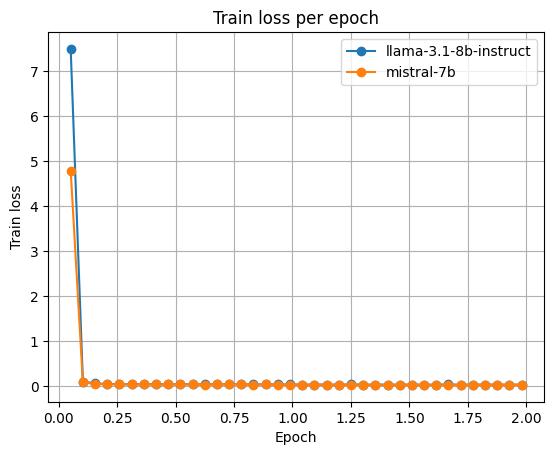

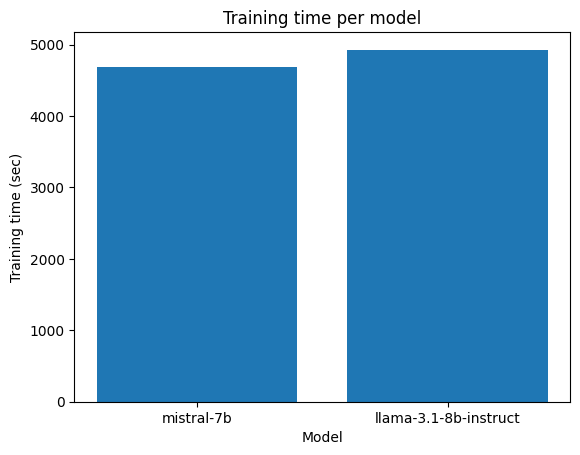

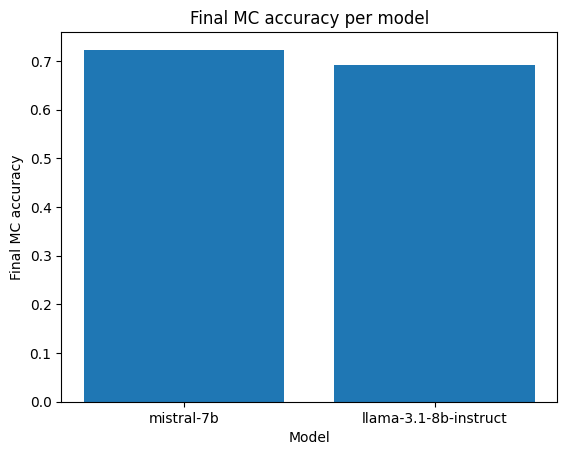

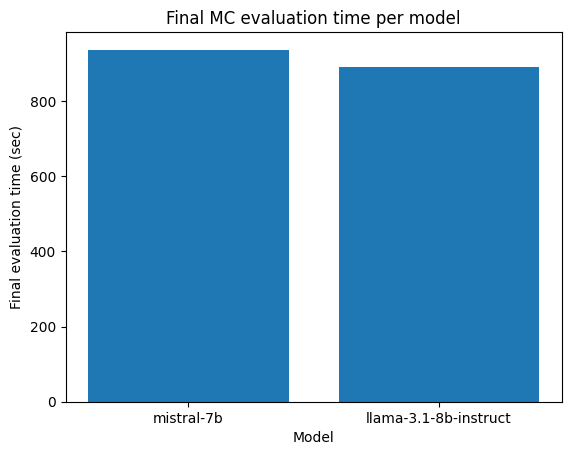

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1) Line plot: train loss per epoch for each model
plt.figure()

if "epoch" in epoch_results_df.columns and "loss" in epoch_results_df.columns:
    for model_name, group in epoch_results_df.groupby("model_name"):
        # average loss per epoch for smoother curve
        avg_per_epoch = (
            group.dropna(subset=["epoch", "loss"])
                 .groupby("epoch", as_index=False)["loss"]
                 .mean()
                 .sort_values("epoch")
        )
        if len(avg_per_epoch) == 0:
            continue
        plt.plot(
            avg_per_epoch["epoch"],
            avg_per_epoch["loss"],
            marker="o",
            label=model_name,
        )

    plt.xlabel("Epoch")
    plt.ylabel("Train loss")
    plt.title("Train loss per epoch")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("epoch_results_df does not have 'epoch' and 'loss' columns; skipping loss-per-epoch plot.")

# 2) Bar: training time per model
plt.figure()
train_time_series = summary_df["train_time_sec"].fillna(0)
plt.bar(summary_df["model_name"], train_time_series)
plt.xlabel("Model")
plt.ylabel("Training time (sec)")
plt.title("Training time per model")
plt.show()

# 3) Bar: final MC accuracy per model
plt.figure()
final_acc_series = summary_df["final_mc_accuracy"].fillna(0)
plt.bar(summary_df["model_name"], final_acc_series)
plt.xlabel("Model")
plt.ylabel("Final MC accuracy")
plt.title("Final MC accuracy per model")
plt.show()

# 4) Bar: final evaluation time per model
plt.figure()
final_eval_time_series = summary_df["final_eval_time_sec"].fillna(0)
plt.bar(summary_df["model_name"], final_eval_time_series)
plt.xlabel("Model")
plt.ylabel("Final evaluation time (sec)")
plt.title("Final MC evaluation time per model")
plt.show()
